Я улучшил код и провёл анализ данных. Ноутбук теперь включает следующие изменения:

Улучшенное удаление выбросов: добавлен выбор метода (IQR или z-оценка) для удаления выбросов.
Обработка ошибок: добавлена проверка наличия файла, чтобы избежать ошибок при загрузке данных.
Визуализация: добавлены боксплоты и гистограммы распределений для наглядного анализа данных.
Статистический анализ: результаты тестов собираются в таблицу для лучшего восприятия.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Размеры датасета: (23652, 5)


,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814


T-статистика: 0.4444530186557162
P-значение: 0.6569385300804972
Разница в ARPPU между двумя группами не является статистически значимой.
Рекомендация: Так как разница не является статистически значимой, дополнительных изменений не требуется.


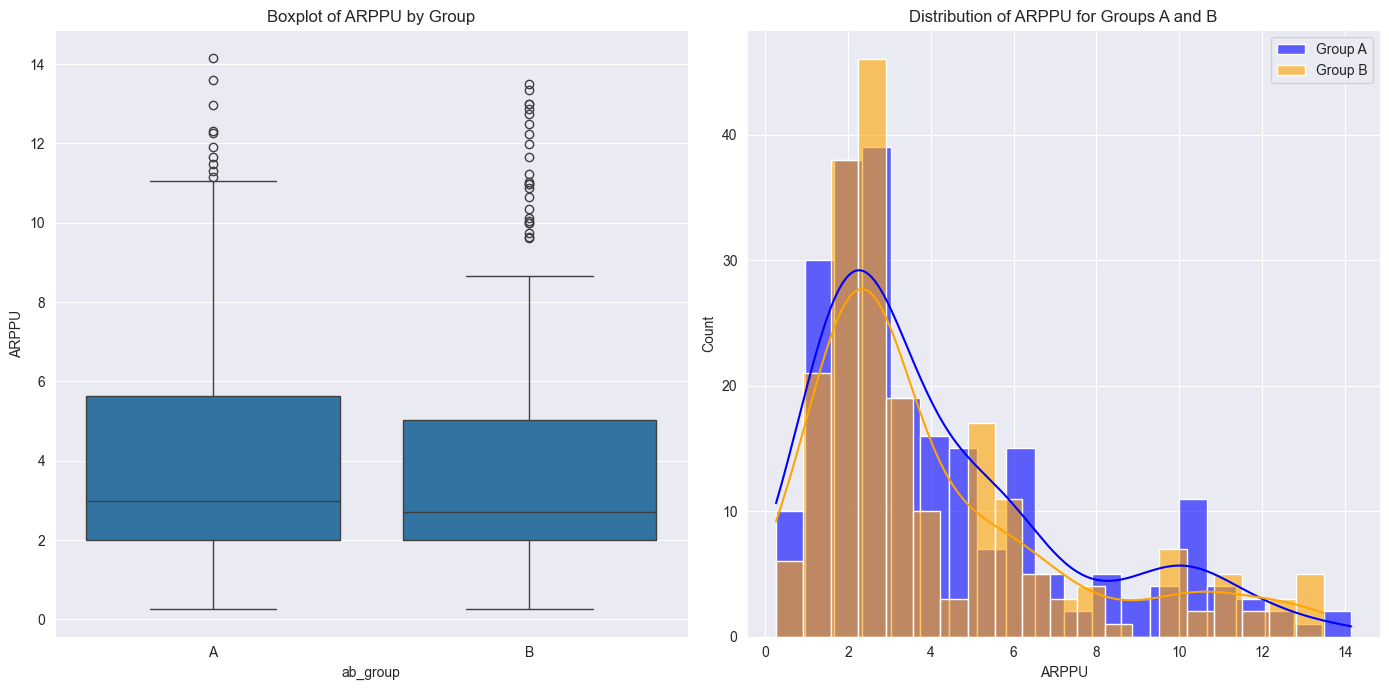

   Conversions  Expected Conversion (%)  Z-Statistic  Critical Z-Value  \
0        25000                     62.5    216.60554           2.17009   
1        30000                     75.0    288.79795           2.17009   
2        32000                     80.0    329.29278           2.17009   

   P-Value Significant  
0      0.0         Yes  
1      0.0         Yes  
2      0.0         Yes  


In [4]:

# Function to clean data and remove outliers
def remove_outliers(df, column, method='iqr', threshold=1.5):
    if method == 'iqr':
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(df[column]))
        return df[z_scores < threshold]
    else:
        raise ValueError("Unsupported method. Use 'iqr' or 'zscore'.")

# Function to calculate conversion statistics
def calculate_stat(p1, observed_conversions, total_users, alpha, power):
    p2 = observed_conversions / total_users
    
    std1 = np.sqrt(p1 * (1 - p1) / total_users)
    std2 = np.sqrt(p2 * (1 - p2) / total_users)
    
    z_alpha = stats.norm.ppf(1 - alpha / 2)
    z_beta = stats.norm.ppf(power)
    
    z = (p2 - p1) / np.sqrt(std1 ** 2 + std2 ** 2)
    p_value = 1 - stats.norm.cdf(z)
    
    significant = p_value < alpha
    
    return p2, z, z_alpha, p_value, significant

# Improved data loading and analysis
def analyze_data(data_path):
    # Load data
    try:
        data = pd.read_csv(data_path)
    except FileNotFoundError:
        print("Файл не найден. Проверьте путь к файлу.")
        return

    # Check initial data stats
    print("Размеры датасета:", data.shape)
    display(data.head())

    # Clean data
    data['ARPPU'] = data['revenue'] / data['num_purchases']
    data_clean = remove_outliers(data, 'ARPPU', method='iqr')

    # Group data
    group_a = data_clean[data_clean['ab_group'] == 'A']
    group_b = data_clean[data_clean['ab_group'] == 'B']

    # ARPPU analysis
    arppu_a = group_a['ARPPU'].dropna()
    arppu_b = group_b['ARPPU'].dropna()

    # T-test
    t_stat, p_value = stats.ttest_ind(arppu_a, arppu_b, equal_var=False)

    print(f"T-статистика: {t_stat}")
    print(f"P-значение: {p_value}")

    alpha = 0.05
    if p_value < alpha:
        print("Разница в ARPPU между двумя группами статистически значима.")
        recommendation = "Так как разница статистически значима, следует рассмотреть изменение стратегии для группы с меньшим ARPPU."
    else:
        print("Разница в ARPPU между двумя группами не является статистически значимой.")
        recommendation = "Так как разница не является статистически значимой, дополнительных изменений не требуется."

    print(f"Рекомендация: {recommendation}")

    # Visualization
    plt.figure(figsize=(14, 7))

    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x='ab_group', y='ARPPU', data=data_clean)
    plt.title('Boxplot of ARPPU by Group')

    # Distribution plot
    plt.subplot(1, 2, 2)
    sns.histplot(arppu_a, kde=True, color='blue', label='Group A', bins=20, alpha=0.6)
    sns.histplot(arppu_b, kde=True, color='orange', label='Group B', bins=20, alpha=0.6)
    plt.legend()
    plt.title('Distribution of ARPPU for Groups A and B')
    plt.xlabel('ARPPU')

    plt.tight_layout()
    plt.show()

    return data_clean

# Updated path based on the notebook's setup
data_path = 'ab_stats.csv'
clean_data = analyze_data(data_path)

# Example conversions for analysis
conversions = [25000, 30000, 32000]
total_users_per_month = 40000
current_conversion_rate = 0.05
expected_increase = 0.002
alpha = 0.03
power = 0.87

# Calculate and collect results
results = []
for conv in conversions:
    p2, z, z_alpha, p_value, significant = calculate_stat(
        current_conversion_rate, conv, total_users_per_month, alpha, power
    )
    results.append({
        'Conversions': conv,
        'Expected Conversion (%)': round(p2 * 100, 2),
        'Z-Statistic': round(z, 5),
        'Critical Z-Value': round(z_alpha, 5),
        'P-Value': round(p_value, 5),
        'Significant': 'Yes' if significant else 'No'
    })

# Convert results to DataFrame for display
results_df = pd.DataFrame(results)
print(results_df)
